### Es gibt viele Deep-Learning Packages : 
- Torch
- Caffe
- Theano (Keras, Lasagne)
- Tensorflow
- etc

### Wie unterscheiden sie sich?
1. *Configuration file* (Caffe, CNTK) vs *Programmatic Generation* ( Torch, Theano, Tensorflow)
2. high level language : Python (theano, Tensorflow) vs Lua 

### Was ist TensorFlow?
- ein Deep Learning Library von Google, jetzt open source
- definiert primitive um funktionen mit Tensoren aufzubauen
- automatische Berechnung die Ableitung von Tensoren
- "TensorFlow computations are expressed as stateful dataflow graphs"
- "takes com- putations described using a dataflow-like model and maps them onto a wide variety of different hardware platforms"

### Was ist ein Tensor?
- matematische Beschreibung von einheits Vektoren 
- a typed, multidimensional array
- wichtig : ein Skalar ist ein tensor mit index 1, ein vector ist ein tensor mit index 2, matrix 3 (immer reshape() benutzen)

In [5]:
import numpy as np

a = np.zeros((2,2))
b = np.ones((2,2))

print(np.sum(b,axis=1))
print(a.shape)
print(np.reshape(a,(1,4)))


[ 2.  2.]
(2, 2)
[[ 0.  0.  0.  0.]]


In [14]:
import tensorflow as tf

a = tf.zeros((2,2))
b = tf.ones((2,2))

sesh = tf.Session()
print(sesh.run(tf.reduce_sum(b,reduction_indices=1)))
print(a.get_shape())
print(sesh.run(tf.reshape(a,(1,4))))
sesh.close()

[ 2.  2.]
(2, 2)
[[ 0.  0.  0.  0.]]


### TensorFlow definiert ein 'Computation Graph'
"TensorFlow programs are usually structured into a construction phase, that assembles a graph, and an execution phase that uses a session to execute ops in the graph" - tensorflow docs
- wir mussen explizit 'run()' auf ein session rufen
- sonnst passiert nichts



In [7]:
shape = (2,2)
a = np.zeros(shape)
ta = tf.zeros(shape)

print("Here is a : ")
print(a)
print("ta vor 'run'")
print(ta)
print("ta nach 'run'")
print(sesh.run(ta))

Here is a : 
[[ 0.  0.]
 [ 0.  0.]]
ta vor 'run'
Tensor("zeros_1:0", shape=(2, 2), dtype=float32)
ta nach 'run'
[[ 0.  0.]
 [ 0.  0.]]


### Sessions
" A Session object encapsulates the environment in which Tensor objects are evaluated"
- kann entweder 'tf.InteractiveSession()' laufen, dann operation.eval() 
- oder ein tf.Session() definieren und run() 

In [8]:
a = tf.constant(5.0)
b = tf.constant(10.0)
c = a*b

with tf.Session() as sess:
    print(sess.run(c))
    print(c.eval())

50.0
50.0


### Variables und Placeholders
- Variables : für interne daten Strukturen
- Placeholders : für input/output

#### Variables
"When you train a model you use variables to hold and update parameters. Variables are in memory buffers containing tensors." - TensorFlow Docs

In [9]:
a = tf.Variable(tf.zeros(shape),name="a")
b = tf.Variable(tf.random_normal(shape),name="b")
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(sess.run(a))
    print(sess.run(b))

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.25100324 -0.55892378]
 [ 1.12517929  0.02812252]]


In [10]:
# build computation graph : 
a = tf.Variable(0,name="counter")
b = tf.add(a,tf.constant(1))
update = tf.assign(a,b)

# execute the graph : 
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print(sess.run(a))
    for _ in range(3):
        sess.run(update)
        print(sess.run(a))

0
1
2
3


sess.run(variable) gibt den Wert von variable zurück

In [11]:
a = tf.constant(3.0)
b = tf.constant(2.0)
c = tf.constant(8.0)
b_plus_c = tf.add(b,c)
a_mal_bc = tf.mul(a,b_plus_c)

with tf.Session() as sess:
    d = sess.run([a_mal_bc,b_plus_c])
    print(d)

[30.0, 10.0]


#### Placeholders
Bis jetzt haben wir explizit tensoren definiert. Normaleweise wollen wir externe Data rein speisen. wir machen dass mit Numpy und Feed Dictionaries

In [12]:
# explizit mit convert_to_tensor
a = np.zeros((shape))
ta = tf.convert_to_tensor(a)
with tf.Session() as sess:
    print(sess.run(ta))

[[ 0.  0.]
 [ 0.  0.]]


In [13]:
# mit feed dictionaries
# dictionary mapping from tf.placeholder to data (numpy, lists, etc)
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)
a_mal_b = tf.mul(a,b)
with tf.Session() as sess:
    print(sess.run([a_mal_b],
                   feed_dict = {a:[8.],b:[9.]}))

[array([ 72.], dtype=float32)]


## Variable Scope
- tf.variable_scope() für einfache name-spacing
- tf.get_variable() um variablen zu kriegen/generieren (default reuse = False, schafft neue variable, reuse = True sucht und gibt ValueError wenn nicht existiert)

In [23]:
with tf.variable_scope("layer1",reuse=True):
    with tf.variable_scope("inside_layer1",reuse=True):
        v = tf.get_variable("v",[1])
print(v.name)

layer1/inside_layer1/v:0


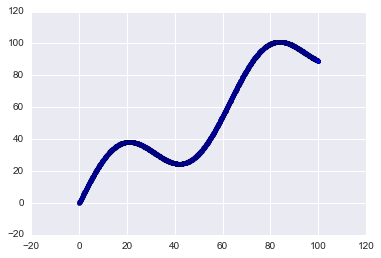

In [72]:
## Linear Regression in TF
import numpy as np
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

# make the data
x_data = np.arange(100,step=.1)
y_data = x_data+np.sin(x_data/10)*20

# plot the data
plt.scatter(x_data,y_data)

n_samples = 1000
batch_size = 100

x_data = np.reshape(x_data,(n_samples,1))
y_data = np.reshape(y_data,(n_samples,1))

x = tf.placeholder(tf.float32,shape=(batch_size,1))
y = tf.placeholder(tf.float32,shape=(batch_size,1))

with tf.variable_scope("linear-regression",reuse=True):
    w = tf.get_variable("weights",(1,1),
                        initializer = tf.random_normal_initializer())
    b = tf.get_variable("bias",(1,),
                        initializer=tf.constant_initializer(0.0))
    y_pred = tf.matmul(x,w)+b
    loss = tf.reduce_sum((y-y_pred)**2/n_samples)

### 1 Training Schritt

In [73]:
# gradient descent optimierung algorithmus definieren
opt = tf.train.AdamOptimizer()

# tensorflow scope ist nicht python scope! kann immernoch loss sehen
opt_operation = opt.minimize(loss)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    x_batch,y_batch = x_data[indices], y_data[indices]
    _,loss_val = sess.run([opt_operation,loss],
                          feed_dict={x:x_batch,y:y_batch})
    print("Loss val ist : %f"%loss_val)

Loss val ist : 934.726074


In [74]:
opt_operation = tf.train.AdamOptimizer().minimize(loss)
weight,bias = 0,0
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    
    for i in range(500):
        indices = np.random.choice(n_samples,batch_size)
        x_batch,y_batch = x_data[indices], y_data[indices]
        _,loss_val,weight,bias = sess.run([opt_operation,loss,w,b],
                             feed_dict = {x:x_batch,y:y_batch})
        if (i%100 == 0):
            print("Loss val ist : %f"%loss_val)
            print("y = %0.2fx + %0.2f"%(weight,bias))

Loss val ist : 33.593842
y = 1.28x + -0.00
Loss val ist : 24.006998
y = 1.18x + -0.09
Loss val ist : 16.704872
y = 1.12x + -0.15
Loss val ist : 18.761545
y = 1.08x + -0.17
Loss val ist : 18.057312
y = 1.06x + -0.16


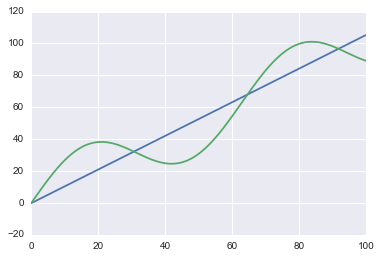

In [75]:
plt.plot(x_data,x_data*weight+bias)
plt.plot(x_data,y_data)
plt.show()

- tf.train.Optimizer ist ein optimizer
- tf.train.Optimizer.minimize(loss,var_list) baut die optimierung in unsere computation graph ein
- automatische differenzierung!! ohne user input!

### White paper to TensorFlow
The white paper is [here](http://download.tensorflow.org/paper/whitepaper2015.pdf). 
TensorFlow computation described by a graph composed of a set of nodes. Each node represents (the instantiation of) an *operation*, has zero or more inputs/outputs. Values that flow along normal edges are tensors (arbitrary dimensionality arrays)
- special edges called *control dependencies* can also exist : no data flows along such edges, but say source node must finish before execution of destination node (enforce happens before relationships)
- an *operation* represents an abstract computation, has a name (eg matrix multiply, add). Can have attributes (eg make polymorphic so can add int/float tensors)
- a *kernel* is a particular implementation of an operation that can run on a particular type of device (eg CPU/GPU)
- the *session* allows client programs to interact with tf system. Computational graph is empty when session created, session adds nodes/edges with extend. Run takes a set of output names that need to be computed as well as an optional set of tensors to be fed into the graph. Arranges and executes appropriate nodes in order that respect their dependencies.
- usually set up a session with a graph once and then execute the full graph thousands/millions of times with run calls.
- most tensors do not survive past a single execution in a graph. A *variable* is a special kind of operation that returns a handle to a persistent mutable tensor that survives across executions of a graph.
- automatic differentiation : when need to compute gradient of C with respect to I, then tf finds the path in computation graph from I to C. Then backtracks from C to I and, for each operation in the backward path, adds a node to the tf graph, compsoing the partial gradients alon gthe backwards path using the chain rule. This added node computes the 'gradient function' for the corresponding operation in the forward path. Any operation can register a gradient function. This function takes as input not only partial gradients computed already along backward path, but also (optionally) inputs/outputs of the forward operation. 

- can run the graph from any node (subgraphs) using run.Run() takes output nodes and input data (using feed_dict). Feed and Fetch nodes are then added to graph (have operations for inputing/saving data). Once added the set of nodes required for execution is determined by starting at each output node and working backward in the graph using graph dependences to determine full set of nodes to be run